# Churn Prediction - Como Antecipar a Evasão de Clientes com Machine Learning

Em mercados competitivos, a retenção do cliente é tão importante quanto a sua conquista. *Churn rate*, ou simplesmente *churn*, representa a taxa de evasão da sua base de clientes. Em serviços como Spotify ou Netflix, ela representaria a taxa de cancelamento de assinaturas.

*Por que isso importa?* Reter clientes custa menos do que consquistá-lo - `Custo de Aquisição de Cliente (CAC)`. Um alto *churn* pode indicar problemas na experiência do cliente, na proposta de valor, ou na concorrência. Ou seja, um alto valor para o *churn rate* é o que não desejamos.

<p align=center>
<img src="https://raw.githubusercontent.com/carlosfab/dsnp2/master/img/churnrate.jpg" width="60%"></p>

Com modelos de machine learning, é possível identificar padrões comportamentais que antecedem o cancelamento. Isso permite que empresas atuem proativamente, oferecendo incentivos, promoções ou mudanças no serviço para evitar perdas.

## Fonte dos Dados

Os dados utilizados neste projeto foram originalmente disponibilizados na plataforma de ensino da [IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#), e tratam de um problema típico de uma companhia de telecomunicações. O *dataset* completo pode ser encontrado [neste link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Cada registro representa um cliente, com atributos como:

* Tipo de serviço (Internet, Telefone, Etc).

* Forma de Pagamento.

* Tempo como cliente.

* Indicador de *Churn* (Variável Alvo).

In [1]:
# Importando pacotes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="talk", style="dark")
sns.color_palette("Spectral", n_colors=5)

# Importando Dados
PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(PATH)

# Conferindo o Dataset
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Análise Exploratória dos Dados

Antes de aplicar qualquer tipo de modelo preditivo, é crucial entender a estrutura e os padrões presentes nos dados. Nesta etapa, exploramos as variáveis, tratamos inconsistências e extraímos insights preliminares que ajudam na modelagem posterior.

**Observações Iniciais** 

*   A coluna `customerID` é apenas um identificador único, sem valor preditivo e será removida.

*   A variável alvo é `Churn`, indicando se o cliente deixou ou não a operadora

*   A coluna `TotalCharges` deveria ser numérica, mas encontra-se como string - será convertida para float. 

Após essa conversão, realizamos uma nova verificação de dados ausentes, que podem ter sido mascarados pelo tipo incorreto em que se encontra.

*   Muitas colunas apresentam dados binários (`Yes/No`), que precisam ser transformados em valores numéricos ao longo do pré-processamento.

In [240]:
print("Dimensões do Dataset")
print("Linhas: \t\t{}".format(df.shape[0]))
print("Colunas: \t\t{}".format(df.shape[1]))

Dimensões do Dataset
Linhas: 		7043
Colunas: 		21


In [241]:
print("Dados Ausentes (total): {}\n".format(df.isnull().sum().values.sum()))
print(df.isnull().sum() / df.shape[0])

Dados Ausentes (total): 0

customerID          0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64


In [242]:
print("Nome das Features do Dataset: \n {} \n".format(df.columns.values))

Nome das Features do Dataset: 
 ['customerID' 'gender' 'SeniorCitizen' 'Partner' 'Dependents' 'tenure'
 'PhoneService' 'MultipleLines' 'InternetService' 'OnlineSecurity'
 'OnlineBackup' 'DeviceProtection' 'TechSupport' 'StreamingTV'
 'StreamingMovies' 'Contract' 'PaperlessBilling' 'PaymentMethod'
 'MonthlyCharges' 'TotalCharges' 'Churn'] 



In [243]:
print("Valores únicos por coluna: \n{}".format(df.nunique()))

Valores únicos por coluna: 
customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64


In [244]:
print("Tipo de variáveis de cada coluna: \n{}".format(df.dtypes))

Tipo de variáveis de cada coluna: 
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


In [245]:
df.loc[0]

customerID                7590-VHVEG
gender                        Female
SeniorCitizen                      0
Partner                          Yes
Dependents                        No
tenure                             1
PhoneService                      No
MultipleLines       No phone service
InternetService                  DSL
OnlineSecurity                    No
OnlineBackup                     Yes
DeviceProtection                  No
TechSupport                       No
StreamingTV                       No
StreamingMovies                   No
Contract              Month-to-month
PaperlessBilling                 Yes
PaymentMethod       Electronic check
MonthlyCharges                 29.85
TotalCharges                   29.85
Churn                             No
Name: 0, dtype: object

A análise inicial nos permite observar que: 

* A coluna `customerID` armazena o código do cliente, o que não nos interessa, então pode ser removida.

* A variável alvo está na coluna `Churn`.

* A coluna `TotalCharges` apresenta resultados numéricos, porém no formato de string, portanto precisam ser convertidos para float.

    * Após a transformação, é preciso conferir novamente se há valores ausentes, uma vez que não são acusados quando estão em formato de string.

* Várias features apresentam resultados binários, incluindo a variável alvo, e precisam ser transformados para valores numéricos.


#### Limpeza e Tratamento preliminar dos Dados

In [246]:
# Criando cópia do Dataframe
df_clean = df.copy()

# Remover a coluna "costumerID"
df_clean.drop("customerID", axis=1, inplace=True)

# Converter strings para float
df_clean["TotalCharges"] = pd.to_numeric(df_clean["TotalCharges"], errors="coerce")

In [247]:
# Verificando valores ausentes
print("Valores ausentes em TotalCharges: \t{}".format(df_clean["TotalCharges"].isnull().sum()))

Valores ausentes em TotalCharges: 	11


Como mencionado anteriormente, após a transformação de string para float, foram identificados valores ausentes para a coluna `TotalCharges`. 

Para tratar esses dados ausentes, vamos subsituir pela mediana dos dados.

In [248]:
# Substituindo valores ausentes pela mediana
df_clean["TotalCharges"] = df_clean["TotalCharges"].fillna(df_clean["TotalCharges"].median())

In [249]:
print("Valores ausentes em TotalCharges: \t{}".format(df_clean["TotalCharges"].isnull().sum()))

Valores ausentes em TotalCharges: 	0


### Continuando a Análise Exploratória

Apesar do Dataset ser composto majoritariamente por variáveis categóricas, conferimos o método `describe()` para verificar a distribuição das variáveis numéricas. Através do resultado do describe, notamos que o crescimento dos resultados aparentam ter uma amplitude normal, o que pode indicar que os dados não apresentam outliers.

In [250]:
df_clean.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


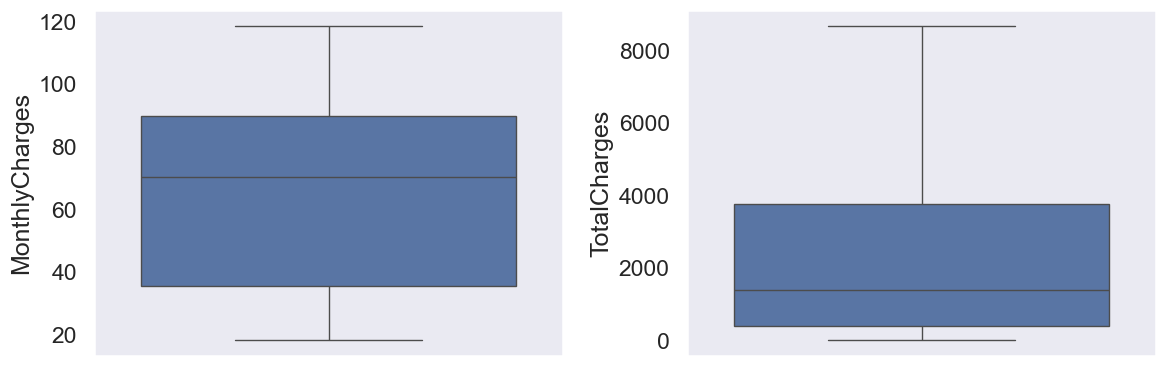

In [251]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
sns.boxplot(df_clean["MonthlyCharges"], ax=ax[0])
sns.boxplot(df_clean["TotalCharges"], ax=ax[1])
plt.tight_layout()

Analisando o `boxplot` para as colunas `MonthlyCharge` e `TotalCharges`, confirma-se que não há presença de outliers nos dados.

A variável `SeniorCitizen` é uma variável binária, que indica se o cliente é Idoso ou não, vemos que 16% dos clientes são idoso.

In [252]:
print("O total de Idosos assinantes é de {}".format(round(df_clean["SeniorCitizen"].value_counts(normalize=False))[1]))
print("Referente à {:.2f}% do total de clientes.".format((df_clean["SeniorCitizen"].value_counts(normalize=True)*100)[1]))

O total de Idosos assinantes é de 1142
Referente à 16.21% do total de clientes.


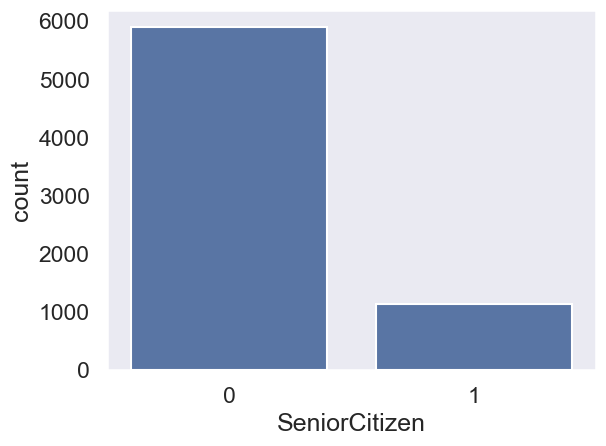

In [253]:
sns.countplot(data=df_clean, x="SeniorCitizen")
plt.tight_layout()

A variável `tenure` indica o tempo de permanência de um cliente assinante, pode-se dizer que é um indicativo de fidelidade. Apensar de não haver nenhum indicativo da métrica, vamos assumir que a unidade de tempo utilizada é `Mês`.

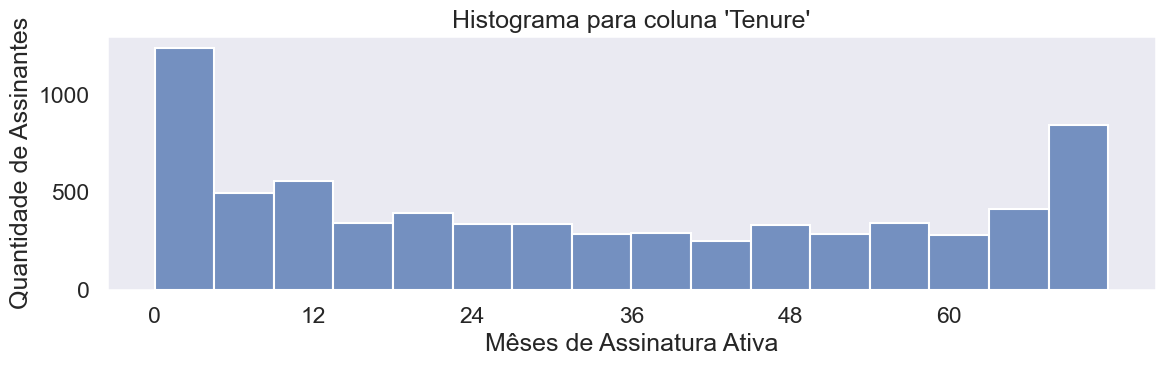

In [254]:
fig, ax = plt.subplots(figsize=(12,4))
sns.histplot(df_clean["tenure"])
plt.xticks(range(0,70,12))
plt.xlabel("Mêses de Assinatura Ativa")
plt.ylabel("Quantidade de Assinantes")
plt.title("Histograma para coluna 'Tenure'")
plt.tight_layout()

Através do histograma da variável `tenure` observamos que após o primeiro ano de assinatura, os clientes tendem a permaencer com a assinatura ativa. 

#### Analisando Variáveis Categóricas

Lidando com variáveis categóricas, é importante conferir os valores únicos, pois permite identificar como os dados são constituídos, idenficar labels diferentes porém com o mesmo significado.

In [255]:
np.unique(df_clean.select_dtypes("object").values)

array(['Bank transfer (automatic)', 'Credit card (automatic)', 'DSL',
       'Electronic check', 'Female', 'Fiber optic', 'Mailed check',
       'Male', 'Month-to-month', 'No', 'No internet service',
       'No phone service', 'One year', 'Two year', 'Yes'], dtype=object)

<Axes: xlabel='gender', ylabel='count'>

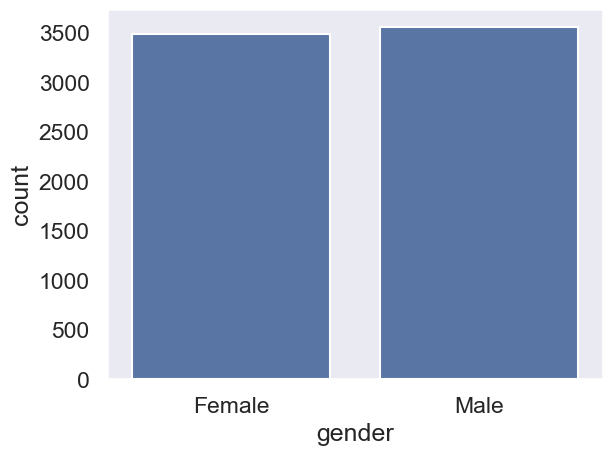

In [256]:
sns.countplot(df_clean, x="gender")

<Axes: xlabel='Churn', ylabel='count'>

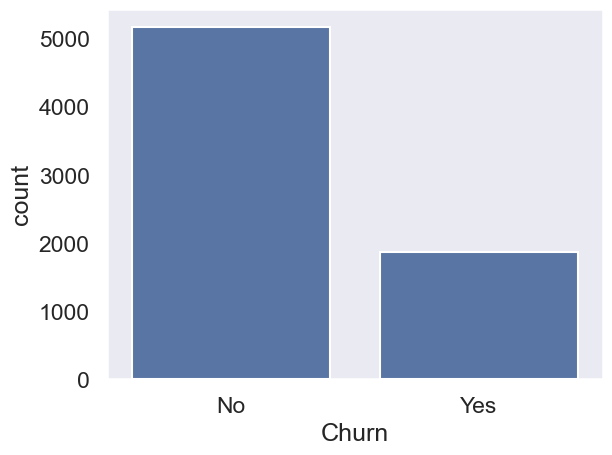

In [257]:
sns.countplot(df_clean, x="Churn")

### Preparação dos Dados

Agora vamos realizar um pré-processamento dos dados para construir a base do nosso modelo de machine learning.

Aqui vamos transformar as features, todas aquelas que contém dois valores únicos, serão transformados para 0 ou 1, utilizando o método `LabelEncoder`. Nessa transformação está inclusa a variável alvo, `Churn`, que apresenta resultados `Yes` ou `No`. As variáveis categóricas serão transformadas em variáveis `dummy`, para facilitar a utilização em diferentes modelos.

In [258]:
# Pré processamento das features
binary_var = df_clean.nunique()[df_clean.nunique() == 2].keys().tolist()
num_var = [col for col in df_clean.select_dtypes(["int", "float"]).columns.tolist() if col not in binary_var]
cat_var = [col for col in df_clean.columns.tolist() if col not in binary_var + num_var]

In [259]:
from sklearn.preprocessing import LabelEncoder

# Criando cópia do dataset
df_prep = df_clean.copy()

# Aplicando o Label Encoding para as features binarias
le = LabelEncoder()
for i in binary_var:
    df_prep[i] = le.fit_transform(df_prep[i])
    
# Encoding para as colunas categóricas
df_prep = pd.get_dummies(df_prep, columns=cat_var)

df_prep.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,True,False,False,True,False,False,False,False,True,False
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,True,False,False,False,True,False,False,False,False,True
2,1,0,0,0,2,1,1,53.85,108.15,1,...,True,False,False,True,False,False,False,False,False,True
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,True,False,False,False,True,False,True,False,False,False
4,0,0,0,0,2,1,1,70.70,151.65,1,...,True,False,False,True,False,False,False,False,True,False


In [260]:
df_prep.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'Churn', 'MultipleLines_No', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No',
       'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMetho

## Modelo de Machine Learning

Agora que os dados estão devidamente limpos e tratados, vamos dar início à construção dos modelos de machine learning. 

Vamos iniciar separando os dados entre, `feature matrix`, `target vector` e então separar a base entre dados de treino e dados de teste.

In [261]:
# importando pacotes
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTENC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from scikitplot.metrics import plot_confusion_matrix, plot_roc

In [262]:
# separar as features
X = df_prep.drop("Churn", axis=1)
y = df_prep["Churn"]

# Dividir entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Usaremos o método de `cross-validation` para estimar o erro dos modelos. Para facilitar a construção do código, abaixo temos uma função `validar_modelo` para que possamos executar diferentes modelos de machine learning de forma mais rápida.

A métrica utilizada para avaliação de cada modelo será `recall`.

In [263]:
def validar_modelo(X, y, clf, quite=False):
    """
    Realiza cross-validation com os dados de treino para determinado modelo.

    # Args:
        X : Dataframe com as variáveis independentes.
        y : Series com a variável alvo.
        clf : Modelo classificador do Scikit-learn.
        quite : bool, indica se a função deve imprimir os resultados ou não
        
    # Returns
        float, média dos scores da cross-validation
    """
    
    X  = np.array(X)
    y = np.array(y)
    
    pipeline = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(pipeline, X, y, scoring="recall")
    
    if quite == False:
        print("Recall: {:.2f} (+/- {:.2f})".format(scores.mean(), scores.std()))
        
    return scores.mean()

Para servir de modelo de base, vamos utilizar o modelo `Random Forest`, com os parâmetros `default`. 

In [264]:
rf = RandomForestClassifier(random_state=42)
score_baseline = validar_modelo(X_train, y_train, rf)

Recall: 0.46 (+/- 0.01)


Agora temos um resultado base, adiquirido através da aplicação "pura" do modelo, sem nenhum tipo de tuning. Vamos então fazer o balanceamento dos dados e conferir o nível de impacto nos resultados.

Para balanceamento dos dados, vamos utilizar o método SMOTENC por ser o mais adequado para lidar com variáveis mistas: numéricas, categóricas.

Não será feita a padronização dos dados, por conta das diversas variáveis com valores booleanos, como resultam apenas 0 e 1, a normalização transformaria os resultados em frações.


In [265]:
# Identificando colunas categóricas
categorical_features = [i for i, col in enumerate(X.columns) if X[col].dtype == "bool"]

# Aplicando o balanceamento dos dados
smote_nc = SMOTENC(categorical_features = categorical_features, random_state=42)
X_train_smote, y_train_smote = smote_nc.fit_resample(X_train, y_train)

In [266]:
# Instanciar modelos
rf = RandomForestClassifier(random_state=42)
dt = DecisionTreeClassifier(random_state=42)
sgdc = SGDClassifier(random_state=42)
svc = SVC(random_state=42)
lr = LogisticRegression(random_state=42)
xgb = XGBClassifier()
lgbm = LGBMClassifier(random_state=42)

# Criando listas vazias para armazenar os resultados
model = []
recall = []

# avaliar o desempenho de todos os modelos

for clf in (rf, dt, sgdc, svc, lr, xgb, lgbm):
    model.append(clf.__class__.__name__)
    recall.append(validar_modelo(X_train_smote, y_train_smote, clf, quite=True))


[LightGBM] [Info] Number of positive: 2908, number of negative: 2908
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 5816, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/marcoasilva/Documents/dsnp/dsnpvenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 2908, number of negative: 2908
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 5816, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/marcoasilva/Documents/dsnp/dsnpvenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 2908, number of negative: 2908
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 5816, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/marcoasilva/Documents/dsnp/dsnpvenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 2908, number of negative: 2908
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 5816, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/marcoasilva/Documents/dsnp/dsnpvenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 2908, number of negative: 2908
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 5816, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/marcoasilva/Documents/dsnp/dsnpvenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [267]:
# Transformar os resultados em um dataframe
resultados = pd.DataFrame(data=recall, index=model)
resultados

,0
RandomForestClassifier,0.838239
DecisionTreeClassifier,0.785144
SGDClassifier,0.819532
SVC,0.815131
LogisticRegression,0.829161
XGBClassifier,0.834663
LGBMClassifier,0.846217


### Otimização dos Parâmetros

In [268]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    "n_estimators" : range(0,1000,50)
}

# identificamndo o melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(rf, param_grid, scoring="recall", cv=kfold, n_jobs=-1)
grid_result = grid_search.fit(X_train_smote, y_train_smote)

/Users/marcoasilva/Documents/dsnp/dsnpvenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/marcoasilva/Documents/dsnp/dsnpvenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/marcoasilva/Documents/dsnp/dsnpvenv/lib/python3.12/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/Users/marcoasilva/Documents/dsnp/dsnpvenv/lib/python3.12/site-packages/sklearn/base.py", 

In [269]:
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8616232252595889 para {'n_estimators': 950}


In [270]:
rf = RandomForestClassifier(n_estimators=250,random_state=42)

param_grid = {
    "max_depth" : range (1,10,1)
}

kfold = StratifiedKFold(n_splits=10, shuffle=True,random_state=42)
grid_search = GridSearchCV(rf, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_smote, y_train_smote)

In [271]:
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))


Melhor: 0.8877584536675446 para {'max_depth': 8}


In [272]:
rf = RandomForestClassifier(n_estimators=250, max_depth=9,random_state=42)

param_grid = {
    "min_samples_leaf": range(0,10,1)
}

kfold = StratifiedKFold(n_splits=10, shuffle=True,random_state=42)
grid_search = GridSearchCV(rf, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_smote, y_train_smote)

/Users/marcoasilva/Documents/dsnp/dsnpvenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/marcoasilva/Documents/dsnp/dsnpvenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/marcoasilva/Documents/dsnp/dsnpvenv/lib/python3.12/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/Users/marcoasilva/Documents/dsnp/dsnpvenv/lib/python3.12/site-packages/sklearn/base.py", 

In [273]:
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8858300790118971 para {'min_samples_leaf': 1}


In [274]:
rf = RandomForestClassifier(n_estimators=250, max_depth=9, min_samples_leaf=3,random_state=42)

param_grid = {
    "min_samples_split": range(0,10,1)
}

kfold = StratifiedKFold(n_splits=10, shuffle=True,random_state=42)
grid_search = GridSearchCV(rf, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_smote, y_train_smote)

/Users/marcoasilva/Documents/dsnp/dsnpvenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/marcoasilva/Documents/dsnp/dsnpvenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/marcoasilva/Documents/dsnp/dsnpvenv/lib/python3.12/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/Users/marcoasilva/Documents/dsnp/dsnpvenv/lib/python3.12/site-packages/sklearn/base.py", 

In [275]:
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))


Melhor: 0.8858270517361427 para {'min_samples_split': 8}


In [276]:
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8858270517361427 para {'min_samples_split': 8}


              precision    recall  f1-score   support

           0       0.89      0.79      0.84      1036
           1       0.56      0.73      0.63       373

    accuracy                           0.78      1409
   macro avg       0.72      0.76      0.74      1409
weighted avg       0.80      0.78      0.78      1409

AUC: 0.7605



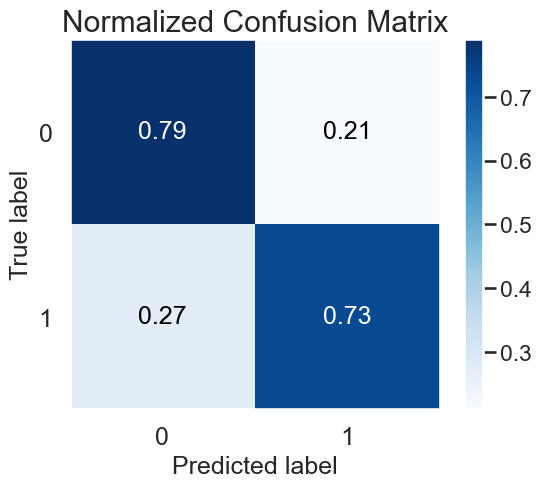

In [277]:
# separar as features
X = df_prep.drop("Churn", axis=1)
y = df_prep["Churn"]

# Dividir entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identificando colunas categóricas
categorical_features = [i for i, col in enumerate(X.columns) if X[col].dtype == "bool"]

# Aplicando o balanceamento dos dados
smote_nc = SMOTENC(categorical_features = categorical_features, random_state=42)
X_train_smote, y_train_smote = smote_nc.fit_resample(X_train, y_train)

# Instanciando o modelo com os hiperparametros 
rf = RandomForestClassifier(n_estimators=250, max_depth=9, min_samples_leaf=3,random_state=42)
rf.fit(X_train_smote, y_train_smote)

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

# imprimir a área sob a curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

# plotar matriz de confusão
plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

              precision    recall  f1-score   support

           0       0.93      0.64      0.76      1036
           1       0.46      0.86      0.60       373

    accuracy                           0.70      1409
   macro avg       0.69      0.75      0.68      1409
weighted avg       0.80      0.70      0.72      1409

AUC: 0.7495



/Users/marcoasilva/Documents/dsnp/dsnpvenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


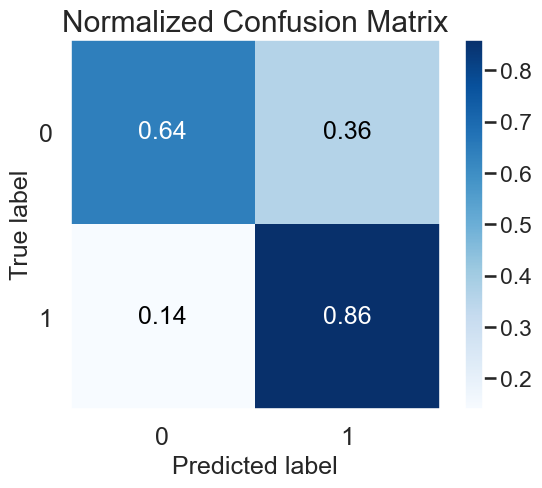

In [278]:
# separar as features
X = df_prep.drop("Churn", axis=1)
y = df_prep["Churn"]

# Dividir entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identificando colunas categóricas
categorical_features = [i for i, col in enumerate(X.columns) if X[col].dtype == "bool"]

# Aplicando o balanceamento dos dados
smote_nc = SMOTENC(categorical_features = categorical_features, random_state=42)
X_train_smote, y_train_smote = smote_nc.fit_resample(X_train, y_train)

# Instanciando o modelo
rf = RandomForestClassifier(n_estimators=250, max_depth=9, min_samples_leaf=3,random_state=42)
rf.fit(X_train_smote, y_train_smote)

# Padronizando dados de Teste
scaler = StandardScaler()
scaler.fit(X_test)
X_test = scaler.transform(X_test)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

# imprimir a área sob a curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

# plotar matriz de confusão
plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()